# Baseline Throughput Plots

Plot the sum throughput and individual throughputs for a deterministic baseline UAV trajectory (straight line from start to end within time L), using the environment's discrete action space.


In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# Add src to path
sys.path.append('../src')

from environment.uav_env import UAVEnvironment
from utils.baseline_policy import choose_greedy_action_to_goal

np.random.seed(42)


In [2]:
def run_baseline_episode(env: UAVEnvironment, distance_tolerance: float = 0.0):
    obs, info = env.reset()
    done = False
    sum_throughput_history = []  # per-step total (sum across users)
    individual_hist = []         # per-step per-user
    channel_quality = []  # 新增：监控信道质量
    # env.set_transmit_strategy(beamforming_method='mrt', power_strategy='equal')

    while not done:
        uav_pos = np.array(info['uav_position'])
        end_pos = np.array(info['end_position'])
        action = choose_greedy_action_to_goal(uav_pos, end_pos, distance_tolerance)
        obs, reward, terminated, truncated, info = env.step(action)
        sum_throughput_history.append(info['throughput'])
        indiv = info.get('individual_throughputs')
        if indiv is None:
            indiv = []
        individual_hist.append(np.array(indiv, dtype=float))

        # 监控信道质量
        user_positions = info['user_positions']
        distances = [np.linalg.norm(uav_pos - np.array(up)) for up in user_positions]
        channel_quality.append(distances)

        done = terminated or truncated
    trajectory = env.get_trajectory()
    # Pad individual history if any step had missing values 
    max_users = max((len(x) for x in individual_hist), default=0)
    if max_users > 0:
        padded = []
        for x in individual_hist:
            if len(x) < max_users:
                y = np.zeros(max_users, dtype=float)
                y[:len(x)] = x
                padded.append(y)
            else:
                padded.append(x)
        individual_hist = np.vstack(padded)
    else:
        individual_hist = np.zeros((len(sum_throughput_history), 0), dtype=float)
    
    # 在notebook中添加调试
    print("User positions:")
    print(env.get_user_positions())

    print("UAV trajectory:")
    traj = env.get_trajectory()
    print(f"Start: {traj[0]}")
    print(f"End: {traj[-1]}")
    print(f"Mid: {traj[len(traj)//2]}")

    return trajectory, sum_throughput_history, individual_hist


In [3]:
# Configure environment
env = UAVEnvironment(
    env_size=(100, 100, 50),
    num_users=2,
    num_antennas=8,
    start_position=(0, 0, 50),
    end_position=(80, 80, 50),
    flight_time=250.0,
    time_step=0.1,
    transmit_power=0.5,
    path_loss_exponent=2.5,
    noise_power=-150.0,
    fixed_users=True,
    seed=42
)


In [4]:
# Run deterministic baseline episode
env.set_transmit_strategy(beamforming_method='mrt', power_strategy='equal')
traj, thr_hist, indiv_hist = run_baseline_episode(env, distance_tolerance=1.0)
sum_thr_cum = np.cumsum(thr_hist)


User positions:
[[13.745401 79.50714   0.      ]
 [77.31994  15.986585  0.      ]]
UAV trajectory:
Start: [ 0.  0. 50.]
End: [78. 78. 50.]
Mid: [39. 39. 50.]


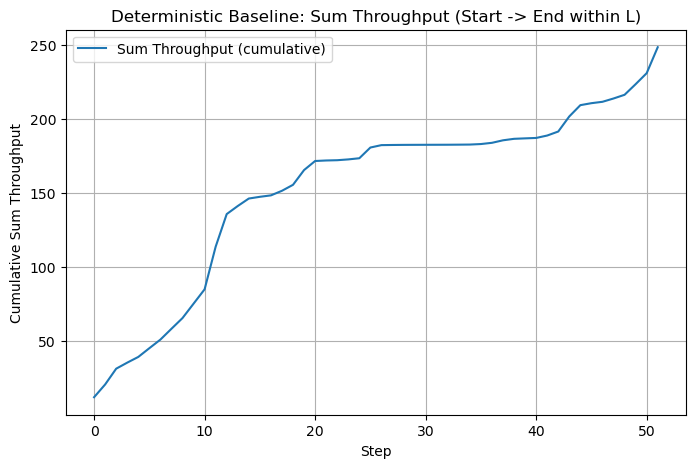

In [5]:
# Plot 1: Sum throughput over time (episode steps)
plt.figure(figsize=(8,5))
plt.plot(sum_thr_cum, label='Sum Throughput (cumulative)')
plt.xlabel('Step')
plt.ylabel('Cumulative Sum Throughput')
plt.title('Deterministic Baseline: Sum Throughput (Start -> End within L)')
plt.grid(True)
plt.legend()
plt.show()


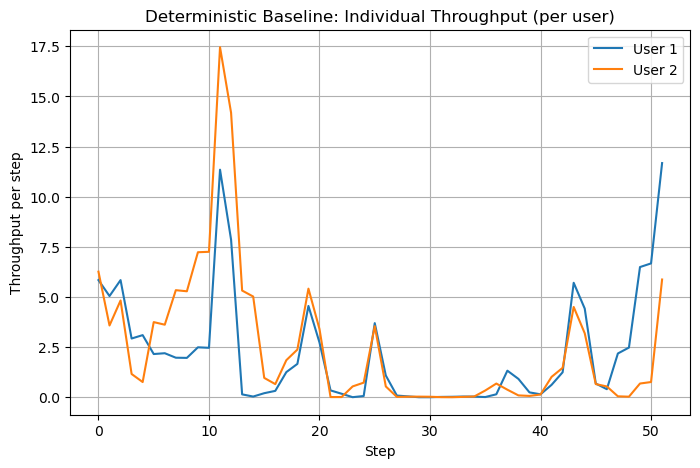

In [6]:
# Plot 2: Individual throughput over time (per-user per-step)
plt.figure(figsize=(8,5))
if indiv_hist.shape[1] == 0:
    plt.text(0.5, 0.5, 'No individual throughput available', ha='center', va='center')
else:
    for u in range(indiv_hist.shape[1]):
        plt.plot(indiv_hist[:, u], label=f'User {u+1}')
plt.xlabel('Step')
plt.ylabel('Throughput per step')
plt.title('Deterministic Baseline: Individual Throughput (per user)')
plt.grid(True)
plt.legend()
plt.show()


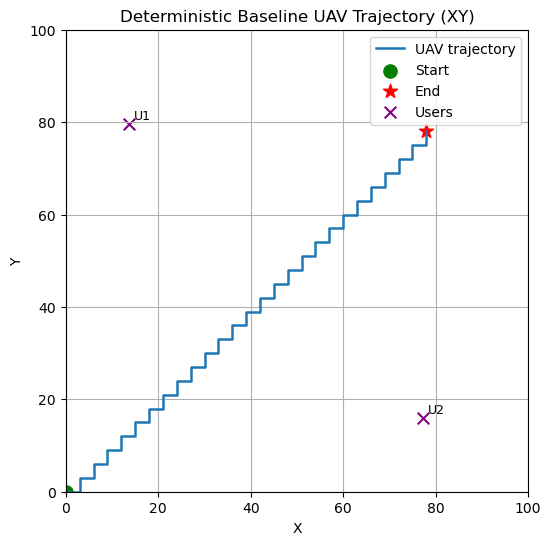

In [7]:
# Plot 3: UAV 2D trajectory with user positions
import numpy as np
import matplotlib.pyplot as plt

traj_arr = np.array(traj)
user_positions = np.array(env.get_user_positions())

plt.figure(figsize=(6,6))
plt.plot(traj_arr[:, 0], traj_arr[:, 1], '-', lw=1.8, label='UAV trajectory')
plt.scatter(traj_arr[0, 0], traj_arr[0, 1], c='green', s=90, marker='o', label='Start')
plt.scatter(traj_arr[-1, 0], traj_arr[-1, 1], c='red', s=110, marker='*', label='End')

if user_positions.size > 0:
    plt.scatter(user_positions[:, 0], user_positions[:, 1], c='purple', s=70, marker='x', label='Users')
    for i, (ux, uy, _) in enumerate(user_positions):
        plt.text(ux + 1, uy + 1, f'U{i+1}', fontsize=9)

plt.xlim(0, env.env_size[0])
plt.ylim(0, env.env_size[1])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Deterministic Baseline UAV Trajectory (XY)')
plt.grid(True)
plt.legend()
plt.show()


In [8]:
# 对比 equal vs proportional 策略的差异
print("=== 对比 Equal vs Proportional 策略 ===")

# 运行 equal 策略
# 在每次运行前打印当前策略
# print(f"id(env) inside run: {id(env)}")
# print(f"Before equal run: env.default_power_strategy = {env.default_power_strategy}")
env.set_transmit_strategy(power_strategy='equal')
# print(f"After setting equal: env.default_power_strategy = {env.default_power_strategy}")
traj_equal, thr_equal, indiv_equal = run_baseline_episode(env)


# print(f"id(env) inside run: {id(env)}")
# 运行 proportional 策略  
# print(f"Before proportional run: env.default_power_strategy = {env.default_power_strategy}")
env.set_transmit_strategy(power_strategy='proportional')
# print(f"After setting proportional: env.default_power_strategy = {env.default_power_strategy}")
traj_prop, thr_prop, indiv_prop = run_baseline_episode(env)

env.set_transmit_strategy(power_strategy='water_filling')
traj_w, thr_w, indiv_w = run_baseline_episode(env)


# 对比关键步骤的差异
key_steps = [0, 5, 10, 15, 20, 25]  # 选择几个关键步骤
print("\n关键步骤的个体吞吐量对比:")
print("Step | Equal策略 | Proportional策略 | Water Filling策略")
print("     | User1 User2 | User1 User2 | User1 User2")
print("-" * 40)

for step in key_steps:
    if step < len(indiv_equal) and step < len(indiv_prop):
        equal_users = indiv_equal[step]
        prop_users = indiv_prop[step]
        w_users = indiv_w[step]
        print(f"{step:4d} | {equal_users[0]:6.3f} {equal_users[1]:6.3f} | {prop_users[0]:6.3f} {prop_users[1]:6.3f} | {w_users[0]:6.3f} {w_users[1]:6.3f}")

# 计算总差异
total_diff = np.sum(np.abs(np.array(thr_equal) - np.array(thr_prop)))
print(f"\n总吞吐量差异: {total_diff:.3f}")

# 计算用户间公平性差异
def calculate_fairness(throughputs):
    if len(throughputs) == 0 or np.sum(throughputs) == 0:
        return 0
    return (np.sum(throughputs) ** 2) / (len(throughputs) * np.sum(throughputs ** 2))

equal_fairness = [calculate_fairness(indiv_equal[i]) for i in range(len(indiv_equal))]
prop_fairness = [calculate_fairness(indiv_prop[i]) for i in range(len(indiv_prop))]

avg_equal_fairness = np.mean(equal_fairness)
avg_prop_fairness = np.mean(prop_fairness)

print(f"Equal策略平均公平性: {avg_equal_fairness:.3f}")
print(f"Proportional策略平均公平性: {avg_prop_fairness:.3f}")
print(f"公平性差异: {avg_equal_fairness - avg_prop_fairness:.3f}")

=== 对比 Equal vs Proportional 策略 ===
User positions:
[[13.745401 79.50714   0.      ]
 [77.31994  15.986585  0.      ]]
UAV trajectory:
Start: [ 0.  0. 50.]
End: [78. 78. 50.]
Mid: [39. 39. 50.]
User positions:
[[13.745401 79.50714   0.      ]
 [77.31994  15.986585  0.      ]]
UAV trajectory:
Start: [ 0.  0. 50.]
End: [78. 78. 50.]
Mid: [39. 39. 50.]
User positions:
[[13.745401 79.50714   0.      ]
 [77.31994  15.986585  0.      ]]
UAV trajectory:
Start: [ 0.  0. 50.]
End: [78. 78. 50.]
Mid: [39. 39. 50.]

关键步骤的个体吞吐量对比:
Step | Equal策略 | Proportional策略 | Water Filling策略
     | User1 User2 | User1 User2 | User1 User2
----------------------------------------
   0 |  5.842  6.261 |  5.706  6.397 |  5.842  6.261
   5 |  2.154  3.747 |  2.101  3.810 |  2.154  3.747
  10 |  2.464  7.253 |  2.313  7.439 |  2.464  7.253
  15 |  0.201  0.964 |  0.190  1.009 |  0.201  0.964
  20 |  2.728  3.399 |  2.528  3.617 |  2.728  3.399
  25 |  3.697  3.545 |  3.596  3.645 |  3.697  3.545

总吞吐量差异: 1.612
Equa

User positions:
[[13.745401 79.50714   0.      ]
 [77.31994  15.986585  0.      ]]
UAV trajectory:
Start: [ 0.  0. 50.]
End: [78. 78. 50.]
Mid: [39. 39. 50.]
User positions:
[[13.745401 79.50714   0.      ]
 [77.31994  15.986585  0.      ]]
UAV trajectory:
Start: [ 0.  0. 50.]
End: [78. 78. 50.]
Mid: [39. 39. 50.]
User positions:
[[13.745401 79.50714   0.      ]
 [77.31994  15.986585  0.      ]]
UAV trajectory:
Start: [ 0.  0. 50.]
End: [78. 78. 50.]
Mid: [39. 39. 50.]


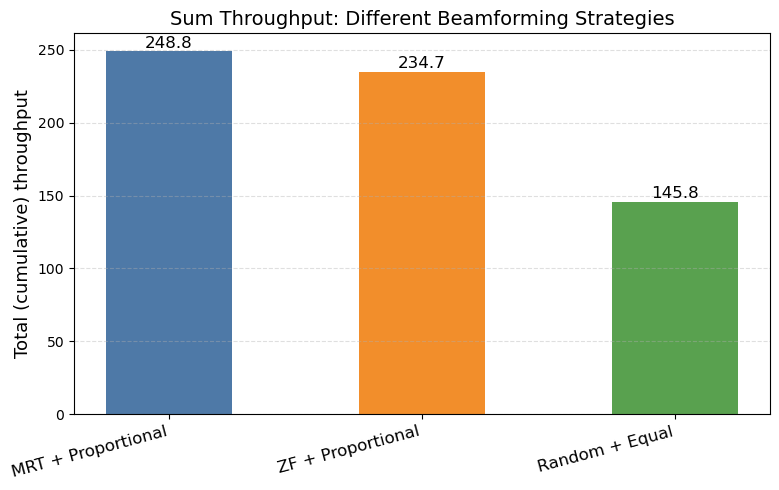

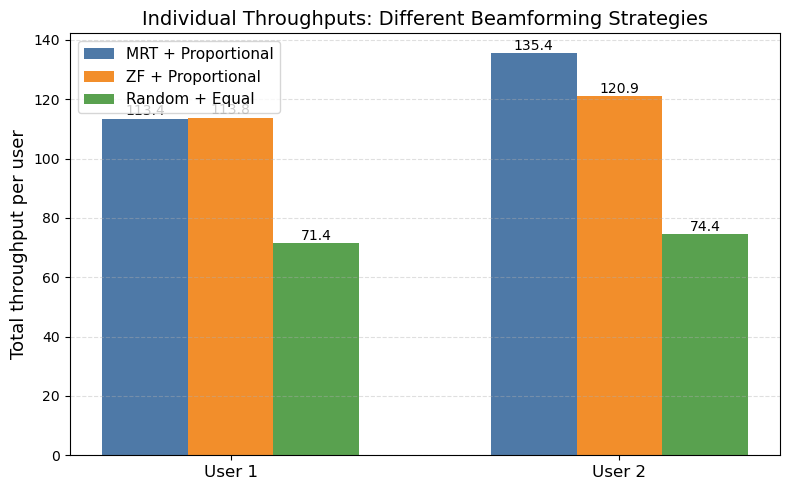

In [9]:
# Bar plots: Compare optimized-signal vs randomized-beamformers on deterministic path
import numpy as np
import matplotlib.pyplot as plt

# Helper to run one scenario and summarize
def run_and_summarize(env, beamforming_method, power_strategy, label):
    env.set_transmit_strategy(beamforming_method=beamforming_method, power_strategy=power_strategy)
    traj_i, thr_hist_i, indiv_hist_i = run_baseline_episode(env)
    total_sum = float(np.sum(thr_hist_i))
    indiv_totals = np.sum(indiv_hist_i, axis=0) if indiv_hist_i.size else np.array([])
    return {
        'label': label,
        'total_sum': total_sum,
        'indiv_totals': indiv_totals,
        'K': len(indiv_totals)
    }

results = []

# 重新整理画图部分，增加颜色区分、数值标注、风格美化

# 重新运行三种策略
results = []

res_mrt_prop = run_and_summarize(env, beamforming_method='mrt', power_strategy='proportional',
                                 label='MRT + Proportional')
results.append(res_mrt_prop)

res_zf_prop = run_and_summarize(env, beamforming_method='zf', power_strategy='proportional',
                                label='ZF + Proportional')
results.append(res_zf_prop)

res_rand_eq = run_and_summarize(env, beamforming_method='random', power_strategy='equal',
                                label='Random + Equal')
results.append(res_rand_eq)

# 颜色设置
bar_colors = ['#4e79a7', '#f28e2b', '#59a14f']

# 总吞吐量柱状图
plt.figure(figsize=(8,5))
labels = [r['label'] for r in results]
values = [r['total_sum'] for r in results]
bars = plt.bar(range(len(values)), values, color=bar_colors[:len(values)], width=0.5)

# 在柱子上标注数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}", 
             ha='center', va='bottom', fontsize=12)

plt.xticks(range(len(values)), labels, rotation=15, ha='right', fontsize=12)
plt.ylabel('Total (cumulative) throughput', fontsize=13)
plt.title('Sum Throughput: Different Beamforming Strategies', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 各用户吞吐量分组柱状图
K = max((r['K'] for r in results), default=0)
if K > 0:
    x = np.arange(K)
    width = 0.22
    plt.figure(figsize=(8,5))
    for idx, r in enumerate(results):
        vals = r['indiv_totals']
        # pad if some runs had fewer users reported
        if len(vals) < K:
            tmp = np.zeros(K)
            tmp[:len(vals)] = vals
            vals = tmp
        bars = plt.bar(x + (idx - (len(results)-1)/2)*width, vals, width=width, 
                       label=r['label'], color=bar_colors[idx % len(bar_colors)])
        # 在柱子上标注数值
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.1f}", 
                     ha='center', va='bottom', fontsize=10)
    plt.xticks(x, [f'User {i+1}' for i in range(K)], fontsize=12)
    plt.ylabel('Total throughput per user', fontsize=13)
    plt.title('Individual Throughputs: Different Beamforming Strategies', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print('No individual throughput available to plot.')
